# Snake

In [1]:
import environments_fully_observable 
import environments_partially_observable
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(0)
import doubleDQN
import AStar_Heuristic
import matplotlib.pyplot as plt



2024-05-23 17:55:06.479256: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 17:55:06.480903: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 17:55:06.509893: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 17:55:06.510259: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 17:55:07.006182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
if tf.config.list_physical_devices('GPU'):
    print('GPU is available.')
else:
    print('GPU is not available. Switching to CPU.')

GPU is not available. Switching to CPU.


2024-05-23 17:55:31.395067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:55:31.395400: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Environment definition

In [3]:
# general variable (train and test)
BOARD_SIZE = 20
GAMMA = .9

# training variables
NUM_BOARDS_TRAIN = 100
BATCH_SIZE = 128
NUM_TRAINING_EPOCHS = 5000

# testing variables
NUM_BOARDS_TEST = 20
TEST_ITERATIONS = 100

In [4]:
# function to display the n boards with suptitle
def display_boards(env, n=5, suptitle=""):
    
    fig,axs=plt.subplots(1,min(len(env.boards), n), figsize=(7,2))
    fig.suptitle(suptitle)
    for ax, board in zip(axs, env.boards):
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.imshow(board, origin="lower")

In [5]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=100, size = 10):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # e = environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e



## Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 64)        2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       147584    
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 256)               10617088  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 10841924 (41.36 MB)
Trainable params: 1084

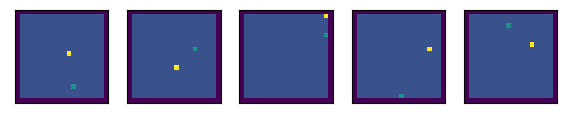

In [6]:
# instantiating the environment
env_ = get_env(n=NUM_BOARDS_TRAIN, size=BOARD_SIZE)
display_boards(env_, 5)

# instantiating the agents
input_shape = env_.to_state().shape[1:]
Double_DQN_agent = doubleDQN.DoubleDQNAgent(input_shape= input_shape, num_actions= 4, gamma= GAMMA)



## Training

In [ ]:
# Training the agent
Double_DQN_agent.train(env_, NUM_TRAINING_EPOCHS, BATCH_SIZE)

# saving the weights
Double_DQN_agent.save_weights(file_prefix=str(BOARD_SIZE))

100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


Mean Reward: 3.5299999713897705


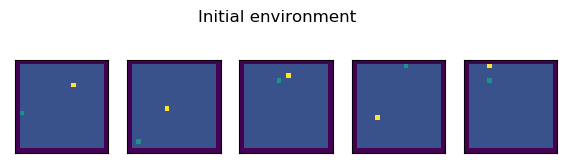

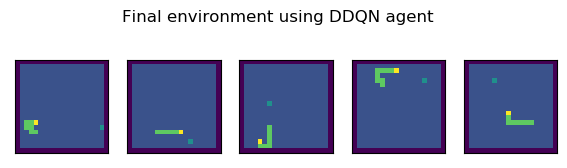

In [10]:
#  ----------------------------------------------------------------------------------------------
# |                                                                                              |
# |                            Testing the RL agent individually                                 |
# |                                                                                              |
#  ----------------------------------------------------------------------------------------------


# instantiating the test environment
env_test = get_env(n=NUM_BOARDS_TEST, size=BOARD_SIZE)
input_shape_test = env_test.to_state().shape[1:]

load_weights = input("Do you want to load the weights of the trained model? (y/n): ")
if load_weights == "y" or load_weights == "Y":
    weights_path = input("Enter the weight file name (only the prefix without _q_model.h5 or _target_q_model.h5): ")
    try:
        Double_DQN_agent.load_weights(weights_path)
        print("weights loaded successfully")
    except:
        print("weights file not found")

display_boards(env_test, 5, "Initial environment")
RL_reward = Double_DQN_agent.play(env_test, TEST_ITERATIONS)
display_boards(env_test, 5, "Final environment using DDQN agent")
print("Mean Reward: {}".format(np.mean(RL_reward)))

100%|██████████| 100/100 [00:04<00:00, 24.53it/s]


Details of the comparison:
number of steps: 100
number of the boards and size:20, 20
Mean Reward of the Astar agent (baseline): 4.05

Mean Reward of the Double DQN agent (RL): 0.07000000774860382

ratio between the mean rewards of RL agent with respect to baseline A* agent is: 

(Mean Reward of the Double DQN agent (RL) / Mean Reward of the Astar agent (baseline): 0.017283952530519463 



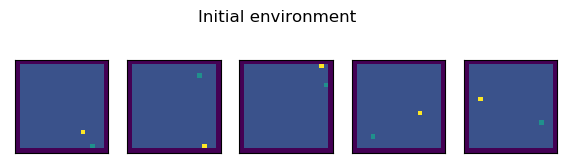

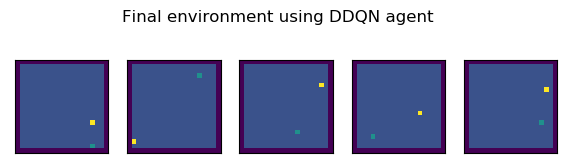

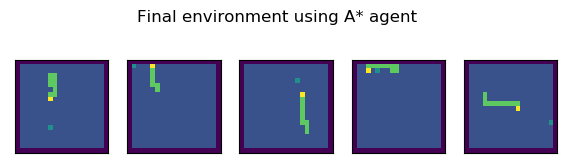

In [9]:
#  ----------------------------------------------------------------------------------------------
# |                                                                                              |
# |                            Comparison between RL agent and baseline                          |
# |                                                                                              |
#  ----------------------------------------------------------------------------------------------

import copy


# creating the reference environment for test comparison
ref_env_ = get_env(NUM_BOARDS_TEST, size=BOARD_SIZE)
input_shape = ref_env_.to_state().shape[1:]

display_boards(ref_env_, 5, "Initial environment")

RL_env_ = copy.deepcopy(ref_env_)
AStar_env_ = copy.deepcopy(ref_env_)

RL_reward = Double_DQN_agent.play(RL_env_, TEST_ITERATIONS)
display_boards(RL_env_, 5, "Final environment using DDQN agent")

# instantiating the Astar agent
AStar_agent = AStar_Heuristic.Heuristic_Agent(AStar_env_)
baseline_reward = AStar_agent.execute(TEST_ITERATIONS)
display_boards(AStar_env_, 5, "Final environment using A* agent")


mean_baseline_reward = np.mean(baseline_reward)
mean_RL_reward = np.mean(RL_reward)

print(f"Details of the comparison:\nnumber of steps: {TEST_ITERATIONS}\nnumber of the boards and size:{NUM_BOARDS_TEST}, {BOARD_SIZE}")
print(f"Mean Reward of the Astar agent (baseline): {mean_baseline_reward}\n")
print(f"Mean Reward of the Double DQN agent (RL): {mean_RL_reward}\n")

print(f"ratio between the mean rewards of RL agent with respect to baseline A* agent is: \n")
print(f"(Mean Reward of the Double DQN agent (RL) / Mean Reward of the Astar agent (baseline): {mean_RL_reward / mean_baseline_reward} \n")
